In [1]:
from cliff_game import CliffGame, Action
from algorithms import Sarsa

In [2]:
cg = CliffGame()
print(cg)

reward = 0



|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [3]:
r, game_over = cg.move(Action.UP)
reward += r
print(reward, game_over)
print(cg)

-1 False

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|   * |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [4]:
seq = [Action.RIGHT, Action.RIGHT, Action.DOWN, Action.RIGHT]

for i, action in enumerate(seq):
    print(f"{i+1}/{len(seq)} Moving {action.name}")
    r, game_over = cg.move(action)
    reward += r
    if game_over:
        print("Game Over")
        break

print("\nTotal reward:", reward)
print(cg)

1/4 Moving RIGHT
2/4 Moving RIGHT
3/4 Moving DOWN
Game Over

Total reward: -103

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [5]:
sarsa = Sarsa(cg)
for i in range(100):
    cg.reset()
    _, _, r = sarsa.run(verbose=True)
    print(" ", r)

++++++++++  -109
++  -101
+++  -102
+++++++++++++++++++++++++++++++++++++++  -138
+++++++++  -108
++++++++++++++++++++++++++++++++++++++++++++++  -145
+++++++++++++++++++++++++++++  -128
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -166
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -171
++++++++++++++++++++++++++++++++++++++++++++++++  -147
+++++++++++++++++++  -118
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -156
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -82
+++  -102
+++++  -104
++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -155
+++++++++++++++++++++++++++++++  -130
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -109
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -72
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  -70
++++++++++++++++++++++++++++++++++

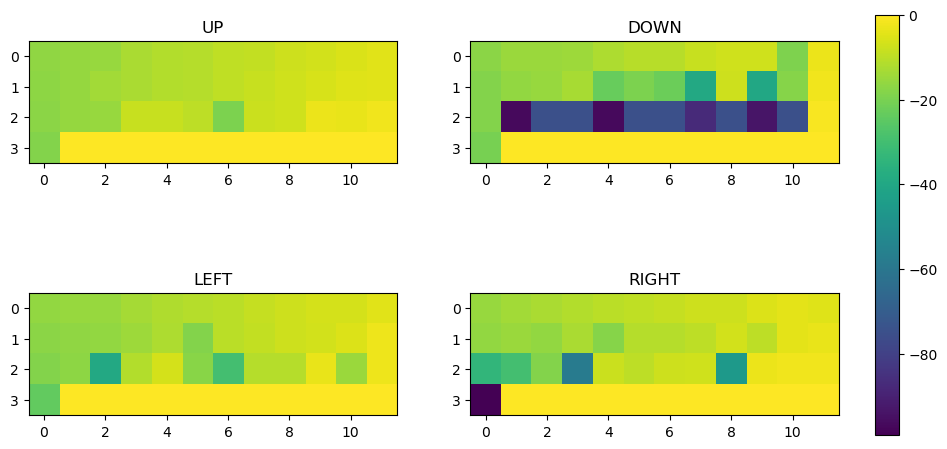

In [6]:
sarsa.plot_q_values()
